## Climbing Weather Dashboard

This Python script displays a weather forecast dashboard for several locations, with a focus on finding the best conditions for rock climbing. 

For each location, the dashboard:

- Uses real-time data from OpenWeatherMap to ensure accurate and up-to-date weather conditions.
- Shows stacked weather graphs for multiple locations, each displaying temperature (°F) and humidity (%) for the upcoming five days.
- Highlights days where temperature and humidity conditions are ideal between 9 AM and 4 PM.

***Note:*** *You must supply your own OpenWeatherMap API key and paste it into the script to run.*

**Follow these instructions:**

1. Visit [OpenWeatherMap](https://openweathermap.org/) and sign up for a free account.
2. After registering, log in to your account.
3. Go to your profile dashboard and find the "API keys" section.
4. Copy the default API key or create a new one.
5. Replace the value of API_KEY below with your key (keep the quotes).

In [ ]:
API_KEY = "apikey" # To use: Insert your own OpenWeatherMap API key here

In [8]:
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

FORECAST_URL = "http://api.openweathermap.org/data/2.5/forecast"

LOCATIONS = {
    "Farley": {"lat": 42.5949, "lon": -72.3678},
    "Rumney": {"lat": 43.9426, "lon": -71.8224},
    "Merriam Woods": {"lat": 43.9948, "lon": -71.6828},
    "The Gunks": {"lat": 41.7459, "lon": -74.0890},
    "Hanging Mountain": {"lat": 42.0618, "lon": -73.1150},
}


Error loading data for The Gunks: HTTPConnectionPool(host='api.openweathermap.org', port=80): Read timed out. (read timeout=None)


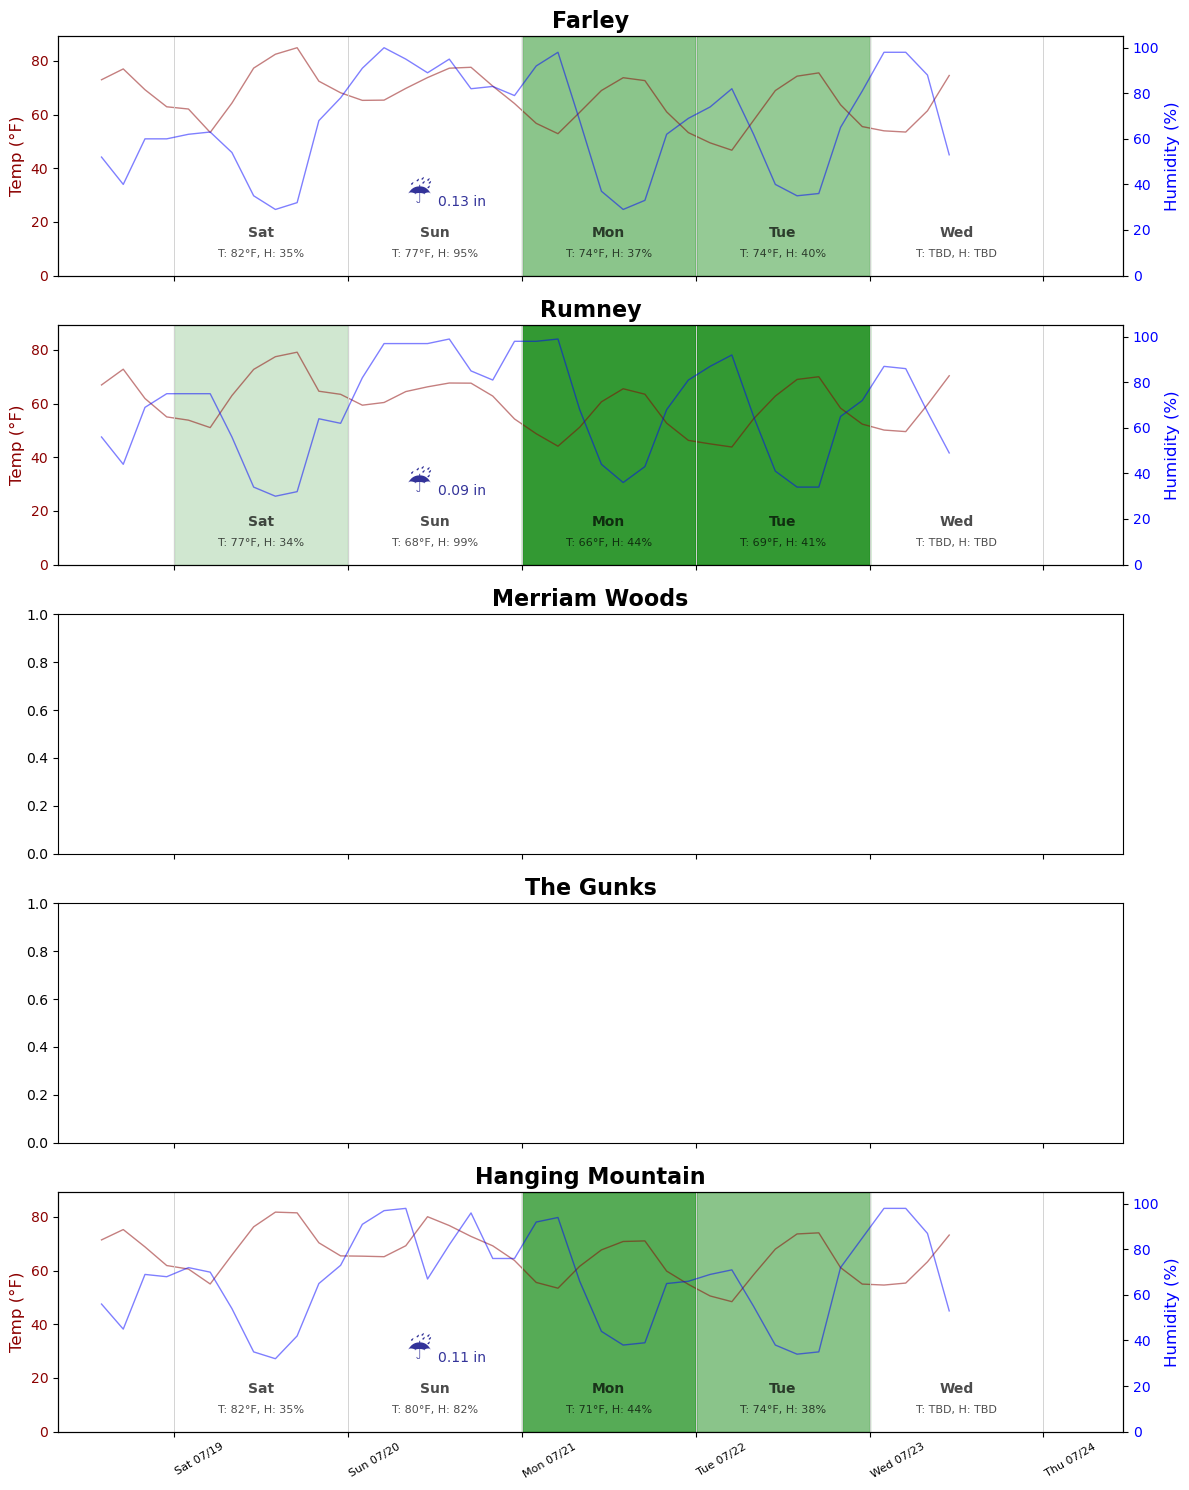

In [6]:
def fetch_forecast_by_coords(lat, lon):
    params = {
        "lat": lat,
        "lon": lon,
        "appid": API_KEY,
        "units": "metric",
    }
    resp = requests.get(FORECAST_URL, params=params)
    resp.raise_for_status()
    return resp.json()

def parse_forecast(data):
    times, temps_c, hums, rain_mm = [], [], [], []
    for entry in data["list"]:
        dt = datetime.fromtimestamp(entry["dt"])
        times.append(dt)
        temps_c.append(entry["main"]["temp"])
        hums.append(entry["main"]["humidity"])
        rain_vol = 0
        if "rain" in entry and isinstance(entry["rain"], dict):
            rain_vol = entry["rain"].get("3h", entry["rain"].get("1h", 0))
        rain_mm.append(rain_vol)
    return times, temps_c, hums, rain_mm

def c_to_f_list(temps_c):
    return [tc * 9/5 + 32 for tc in temps_c]

def daily_metrics_and_alpha_with_rain(times, temps_f, hums, rain_mm, debug=False):
    from collections import defaultdict
    daily_temps = defaultdict(list)
    daily_humidity = defaultdict(list)
    daily_rain = defaultdict(float)
    for t, tf, h, rain in zip(times, temps_f, hums, rain_mm):
        if 9 <= t.hour < 16:
            day = t.date()
            daily_temps[day].append(tf)
            daily_humidity[day].append(h)
            if rain > daily_rain[day]:
                daily_rain[day] = rain
    all_days = sorted({t.date() for t in times})
    alpha_map = {}
    day_metrics = {}
    rain_map = {}
    min_alpha = 0.0
    max_alpha = 0.8
    for day in all_days:
        temps_day = daily_temps.get(day, [])
        hum_day = daily_humidity.get(day, [])
        rain_amt = daily_rain.get(day, 0.0)
        rain_map[day] = rain_amt
        if temps_day and hum_day:
            max_temp = max(temps_day)
            max_hum = max(hum_day)
        else:
            idxs = [i for i, t in enumerate(times) if t.date() == day]
            max_temp = max(temps_f[i] for i in idxs) if idxs else 0
            max_hum = max(hums[i] for i in idxs) if idxs else 0
        day_metrics[day] = (max_temp, max_hum)
        if rain_amt > 0:
            alpha = 0
        else:
            # Calculate temperature score
            if max_temp >= 80 or max_temp <= 32:
                temp_score = 0.0
            elif 60 <= max_temp <= 69:
                temp_score = 1.0
            elif 40 < max_temp < 60:
                temp_score = (max_temp - 40) / (60 - 40)
            elif 69 < max_temp < 80:
                temp_score = (80 - max_temp) / (80 - 69)
            else:
                temp_score = 0.0  # default fallback

            # Calculate humidity score
            if max_hum <= 50:
                hum_score = 1.0
            elif max_hum >= 80:
                hum_score = 0.0
            else:
                hum_score = (80 - max_hum) / (80 - 50)

            combined_score = temp_score * hum_score
            alpha = min_alpha + (max_alpha - min_alpha) * combined_score

        alpha_map[day] = alpha
        if debug:
            print(f"{day} rain(mm):{rain_amt:.2f} max_temp={max_temp:.1f}F max_hum={max_hum:.1f}% alpha={alpha:.3f}")

    return alpha_map, day_metrics, rain_map, all_days

def plot_location_forecast(ax, times, temps_f, hums, alpha_map, day_metrics, rain_map, all_days,
                           loc_name, temp_ylim_max, x_min, x_max, show_xaxis):
    from datetime import datetime, time

    buf = temp_ylim_max * 0.05
    ylim_top = temp_ylim_max + buf
    ax.plot(times, temps_f, color="#8B0000", alpha=0.5, linewidth=1)
    ax.set_ylim(0, ylim_top)
    ax.set_ylabel("Temp (°F)", color="#8B0000", fontsize=12)
    ax.tick_params(axis="y", labelcolor="#8B0000", labelsize=10)
    ax.set_xlim(x_min, x_max)
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %m/%d"))
    if show_xaxis:
        ax.tick_params(axis="x", rotation=30, labelsize=8)
    else:
        ax.tick_params(axis="x", labelbottom=False)

    for label in ax.get_xticklabels():
        label.set_ha('left')

    green_label = "#000000"
    grey_label = "#000000"
    lab_alpha = 0.7
    umbrella_icon = "\u2614"
    first_day = min(all_days) if all_days else None

    for i, day in enumerate(all_days):
        if day == first_day:
            continue  # skip first day label

        # Always draw a vertical line to separate each day
        start_num = mdates.date2num(datetime(day.year, day.month, day.day))
        ax.axvline(start_num, color='lightgrey', linewidth=0.7, linestyle='-')

        # Check if day has any forecast data after 12pm
        has_post_noon_data = any(t.date() == day and t.time() >= time(12, 0) for t in times)
        is_incomplete_day = not has_post_noon_data

        alpha = 0 if is_incomplete_day else alpha_map.get(day, 0)
        max_temp, max_hum = (None, None) if is_incomplete_day else day_metrics.get(day, (0, 0))

        rain_mm = rain_map.get(day, 0.0)
        rain_in = rain_mm / 25.4

        ymin, ymax = ax.get_ylim()
        y_pos = ymin + 0.15 * (ymax - ymin)
        txt_y_pos = y_pos - 0.08 * (ymax - ymin)

        if alpha > 0:
            ax.axvspan(start_num, start_num + 1, color="green", alpha=alpha)
            text_color = green_label
        else:
            text_color = grey_label

        ax.text(start_num + 0.5, y_pos, day.strftime("%a"),
                ha="center", va="bottom", color=text_color, alpha=lab_alpha,
                fontsize=10, fontweight="bold")

        label_text = "T: TBD, H: TBD" if is_incomplete_day else f"T: {max_temp:.0f}°F, H: {max_hum:.0f}%"
        ax.text(start_num + 0.5, txt_y_pos, label_text,
                ha="center", va="bottom", color=text_color, alpha=lab_alpha,
                fontsize=8)

        if rain_in > 0:
            umbrella_x = start_num + 0.48
            rain_x = start_num + 0.52
            umbrella_y = y_pos + 0.13 * (ymax - ymin)
            ax.text(umbrella_x, umbrella_y, umbrella_icon,
                    ha="right", va="bottom", color="navy", fontsize=20, alpha=0.8)
            ax.text(rain_x, umbrella_y, f"{rain_in:.2f} in",
                    ha="left", va="bottom", color="navy", fontsize=10, alpha=0.8)

    # Draw vertical line at the END of the last day
    if all_days:
        last_day = max(all_days)
        end_of_last_day = mdates.date2num(datetime.combine(last_day, datetime.min.time())) + 1
        ax.axvline(end_of_last_day, color='lightgrey', linewidth=0.7, linestyle='-')

    ax2 = ax.twinx()
    ax2.plot(times, hums, color="blue", alpha=0.5, linewidth=1)
    ax2.set_ylim(0, 105)
    ax2.set_ylabel("Humidity (%)", color="blue", fontsize=12)
    ax2.tick_params(axis="y", labelcolor="blue", labelsize=10)
    ax.set_title(loc_name, fontweight="bold", fontsize=16)

def main():
    fig, axes = plt.subplots(len(LOCATIONS), 1,
                             figsize=(12, 3 * len(LOCATIONS)),
                             sharex=True)
    if len(LOCATIONS) == 1:
        axes = [axes]

    all_data = []
    max_temp_global = 0
    all_times = []

    for loc_name, coords in LOCATIONS.items():
        try:
            data = fetch_forecast_by_coords(coords["lat"], coords["lon"])
            times, temps_c, hums, rain_mm = parse_forecast(data)
            temps_f = c_to_f_list(temps_c)
        except Exception as e:
            print(f"Error loading data for {loc_name}: {e}")
            times, temps_f, hums, rain_mm = [], [], [], []
        all_data.append((loc_name, times, temps_f, hums, rain_mm))
        if temps_f:
            mx = max(temps_f)
            if mx > max_temp_global:
                max_temp_global = mx
        all_times.extend(times)

    if not all_times:
        print("No data to plot.")
        return

    x_min = min(all_times) - timedelta(hours=6)
    x_max = max(all_times) + timedelta(days=1)

    for i, (ax, (loc_name, times, temps_f, hums, rain_mm)) in enumerate(zip(axes, all_data)):
        if not times:
            ax.set_title(loc_name, fontweight="bold", fontsize=16)
            continue
        alpha_map, day_metrics, rain_map, all_days = daily_metrics_and_alpha_with_rain(times, temps_f, hums, rain_mm)
        show_xaxis = (i == len(axes) - 1)
        plot_location_forecast(ax, times, temps_f, hums, alpha_map, day_metrics, rain_map, all_days,
                               loc_name, max_temp_global, x_min, x_max, show_xaxis)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()